In [1]:
import pandas as pd
import seaborn as sns
import sklearn as skl
import numpy as np
sns.set(style='darkgrid')

df = pd.read_excel('Base de datos prueba tecnica.xlsx', sheet_name='DB')

# Proprocesamiento de datos
A partir del análisis estadístico y de visualización previamente realizado sobre el conjunto de datos se construye un subconjunto con las variables a utilizar en el modelado del riesgo de no pago. <br>
Dichas variables son seleccionadas por su nivel de correlación con la variable de no_pago evaluadas en el análisis exploratorio. 

In [2]:
columns = ['REGIONAL', 'DEPARTAMENTO', 'portafolio', 'antiguedad_meses', 'Incumplimiento_pago','cliente_id']
data = df[~df['antiguedad_meses'].isna()][columns].copy() # Removemos las filas con antiguedad descononida 
antiguedad_max = data['antiguedad_meses'].max() # Normalizamos variable continua con el valor maximo reportado 
data['antiguedad_meses'] = data['antiguedad_meses'] / antiguedad_max
data.head()

,REGIONAL,DEPARTAMENTO,portafolio,antiguedad_meses,Incumplimiento_pago,cliente_id
0,COSTA,MAGDALENA,Duo,0.056380,0,1004369760
1,COSTA,MAGDALENA,Duo,0.056380,0,1004369760
2,NOROCCIDENTE,ANTIOQUIA,Individual,0.002967,0,1004371304
3,COSTA,MAGDALENA,Trio,0.020772,1,1004382867
4,COSTA,MAGDALENA,Trio,0.020772,1,1004382867


Para el entrenamiento de clasificadores es necesaria la codificacion de las variables categoricas en variables numericas que puedan ser alimentadas al modelo matematico. Se implemente un codificar de tipo one-hot el cual nos retorna un vector disperso para cada categoria presente en la variable a codificar. <br>
Ej: la variable *portafolio* es convertida en 3 columnas de forma que *Individual* - > [1,0,0],   *Duo* -> [0,1,0],   *Trio* -> [0,0,1]

In [3]:
print(data.shape)
print('Numero de categorias en Region:', len(data['REGIONAL'].value_counts().index))
print('Numero de categorias en Departamentos:', len(data['DEPARTAMENTO'].value_counts().index))
print('Numero de categorias en Portafolio:', len(data['portafolio'].value_counts().index))

(18264, 6)
Numero de categorias en Region: 6
Numero de categorias en Departamentos: 21
Numero de categorias en Portafolio: 3


In [4]:
from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder().fit(data[['REGIONAL','DEPARTAMENTO','portafolio']])
coded = encoder.transform(data[['REGIONAL', 'DEPARTAMENTO', 'portafolio']])
# print(encoder.categories_)
ant =  data['antiguedad_meses'].to_numpy().reshape(-1, 1)

X = np.append(coded.toarray(), ant , axis=1)
y = data['Incumplimiento_pago'].to_numpy()
print(f'X shape {X.shape}, y shape: {y.shape}, {type(X)}')

from sklearn.model_selection import cross_validate
cv = 5

X shape (18264, 31), y shape: (18264,), <class 'numpy.ndarray'>


Nuestro conjunto de entrenamiento consiste de 18k muestras con 31 características dispersas y 1 variable objetivo que pueden ser utilizados para construir modelos de clasificación y obtener probabilidades de incumplimiento.


# Exploracion de modelos con validacion cruzada
Para escoger un algoritmo de clasificacion que ofrezca buenos resultados sobre los datos, se utilizan inicialmente tecnicas de validacion cruzada con 5 folds sobre tres de los metodos mas usados en datos de baja y mediana complejidad. 

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)  # Scaler is needed for LR convergence. 
          
reg = LogisticRegression()
cv_results = cross_validate(reg, scaler.transform(X), y, cv=cv, scoring=['recall', 'f1', 'accuracy'])
# print(dict(zip([f'fit split {i}' for i in range(cv)], cv_results['test_score'])))
acc = cv_results['test_accuracy'].mean()
rec = cv_results['test_recall'].mean()
f1 = cv_results['test_f1'].mean()
t = cv_results['fit_time'].mean()
print('Logistic Regression')
print(f'Mean acc between folds: {100*acc:.2f}% \n'
      f'Mean sensitivity time btw folds: {100*rec:.2f}% \n'
     f'Mean f1 time btw folds: {100*f1:.2f}% \n'
     f'Mean fit time btw folds: {t:.2f} secs. ')

Logistic Regression
Mean acc between folds: 85.69% 
Mean sensitivity time btw folds: 0.04% 
Mean f1 time btw folds: 0.08% 
Mean fit time btw folds: 0.09 secs. 


In [6]:
from sklearn.svm import SVC
svm = SVC(probability=True)
cv_results = cross_validate(svm, X, y, cv=cv, scoring=['recall', 'f1', 'accuracy'])
# print(dict(zip([f'fit split {i}' for i in range(cv)], cv_results['test_score'])))
acc = cv_results['test_accuracy'].mean()
rec = cv_results['test_recall'].mean()
f1 = cv_results['test_f1'].mean()
t = cv_results['fit_time'].mean()
print('Support Vector Machine')
print(f'Mean acc between folds: {100*acc:.2f}% \n'
      f'Mean sensitivity time btw folds: {100*rec:.2f}% \n'
     f'Mean f1 time btw folds: {100*f1:.2f}% \n'
     f'Mean fit time btw folds: {t:.2f} secs. ')

Support Vector Machine
Mean acc between folds: 85.66% 
Mean sensitivity time btw folds: 0.92% 
Mean f1 time btw folds: 1.76% 
Mean fit time btw folds: 16.97 secs. 


In [7]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
cv_results = cross_validate(tree, X, y, cv=cv, scoring=['recall', 'f1', 'accuracy'])
# print(dict(zip([f'fit split {i}' for i in range(cv)], cv_results['test_score'])))
acc = cv_results['test_accuracy'].mean()
rec = cv_results['test_recall'].mean()
f1 = cv_results['test_f1'].mean()
t = cv_results['fit_time'].mean()
print('DecisionTree')
print(f'Mean acc between folds: {100*acc:.2f}% \n'
      f'Mean sensitivity time btw folds: {100*rec:.2f}% \n'
     f'Mean f1 time btw folds: {100*f1:.2f}% \n'
     f'Mean fit time btw folds: {t:.2f} secs. ')

DecisionTree
Mean acc between folds: 83.77% 
Mean sensitivity time btw folds: 15.40% 
Mean f1 time btw folds: 21.26% 
Mean fit time btw folds: 0.02 secs. 


Los resultados de la validación cruzada nos muestran que el árbol de decisión genera los mejores resultados en términos de sensibilidad a la clase objetiva.  Sin embargo, los niveles de precisión alcanzados por los otros modelos con baja sensibilidad sugieren la necesidad de técnicas de muestreo que permitan disminuir el desbalance entre clases.

# Entrenamiento de modelos

Posterior a la validacion cruzada, descartamos la regresion lineal y proseguimos el entrenamiento y validacion de los modelos finales en el conjunto de datos de entrenamiento. <br>
Comenzamos separando los sub conjuntos de entrenamiento y validacion.

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

Teniendo en cuenta el desbalanceo de datos es importante utilizar una tecnica de muestreo para atacar el problema de sobre entrenamiento hacia la clase mayoritaria, implementamos RandomUnderSampling para obtener un sub conjunto balanceado de los datos con respecto a la variable objetivo. 

In [9]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

u, c = np.unique(y_resampled, return_counts=True)
print(dict(zip(['cumple' , 'no cumple'], c)))

{'cumple': 1749, 'no cumple': 1749}


Entrenamos el arbol de decisión y svm para proseguir con las validaciones y seleccion.

In [10]:
tree.fit(X_resampled, y_resampled)
print(f'tree mean accuracy: {tree.score(X_test,y_test)}')
tree_pred = tree.predict(X_test)
print(X_resampled.shape)

svm.fit(X_resampled, y_resampled)
print(f'support vector machine mean accuracy: {svm.score(X_test, y_test)}')
svm_pred = svm.predict(X_test)
print(X_resampled.shape)

tree mean accuracy: 0.6590909090909091
(3498, 31)
support vector machine mean accuracy: 0.6250829462508295
(3498, 31)


Obtenemos reporte de clasificacion para ambos modelos y evaluamos el desempeño.

In [11]:
from sklearn.metrics import classification_report

labels  =['Cumplido', 'Incumplido']
print('Desicion Tree Report: \n', classification_report(y_test, tree_pred, target_names=labels))

print('SVM Report: \n', classification_report(y_test, svm_pred, target_names=labels))

Desicion Tree Report: 
               precision    recall  f1-score   support

    Cumplido       0.93      0.65      0.77      5167
  Incumplido       0.25      0.70      0.37       861

    accuracy                           0.66      6028
   macro avg       0.59      0.68      0.57      6028
weighted avg       0.83      0.66      0.71      6028

SVM Report: 
               precision    recall  f1-score   support

    Cumplido       0.92      0.61      0.74      5167
  Incumplido       0.23      0.70      0.35       861

    accuracy                           0.63      6028
   macro avg       0.58      0.66      0.54      6028
weighted avg       0.83      0.63      0.68      6028



### Conclusiones del entrenamiento
A partir de los resultados anteriores podemos determinar el arbol de decision como nuestro modelo escogido en terminos de metricas y eficiencia computacional. <br>
El modelo entrenado presenta una sensibilidad del 70% para la clase de interes (Incumplidos) con un nivel de precision del 25% lo que podria indicar un numero significativo de falsos positivos (clientes de menor riesgo categorizados con un alto riesgo), de forma analoga, la sensibilidad para la clase negativa se ve impactada sin embargo, se logra una alta precision en esta clase garantizando la asertividad de los clientes categoriados como cumplidos. 

# Inferencia

La siguiente casilla nos permite realizar inferencia sobre una muestra generada manualmente en *test_sample*. 
El orden de variables a introducir es: **['REGION', 'DEPARTAMENTO', 'Portafolio', 'antiguedad_meses']**

In [12]:
# test_sample = ['NOROCCIDENTE', 'ANTIOQUIA', 'Individual', 50]
test_sample = ['COSTA', 'ATLÁNTICO', 'Duo', 10]
_input = encoder.transform([test_sample[:-1],]).toarray()
# print(_input.shape)
_input = np.append(_input, np.array((test_sample[-1]/antiguedad_max)).reshape(-1 ,1), axis=1)
# print(_input.shape)
pred = tree.predict(_input)
pred_proba= tree.predict_proba(_input)
print(f'Ciente detectado como {labels[pred[0]]} con una probabilidad de incumplimiento del {100*pred_proba[0,-1]:.2f}%')

Ciente detectado como Cumplido con una probabilidad de incumplimiento del 0.00%


In [13]:
tree_X = tree.predict_proba(X)
svm_X = svm.predict_proba(X)
data['svm_pred'] = svm_X[:,1] 
data['tree_pred'] = tree_X[:,1]

### Procesamiento de la base de datos. 
Realizamos inferencia iterando por todas las filas del data frame original y guardamos la probabilidad de incumplimiento para cada uno de los clientes en una nueva columna llamada *probs_incumplimiento*. 

In [14]:
probs = []
for _, item in enumerate(df[columns].iterrows()):
    _, row = item
    samp_data = row[['REGIONAL', 'DEPARTAMENTO', 'portafolio']].to_list()
    if row[['antiguedad_meses']].isnull()[0]:  
        probs.append('NaN'); continue
    
    try : coded = encoder.transform([samp_data,]) ## Skip entries with uknown column values
    except ValueError: 
        probs.append('NaN'); continue
        
    # print(encoder.categories_)
    ant =  np.array(row['antiguedad_meses']/antiguedad_max).reshape(-1, 1)
    _input = np.append(coded.toarray(), ant , axis=1)
#     print(f'X shape {_input.shape}, {type(_input)}')

    prob = tree.predict_proba(_input)[0, -1]
    
    probs.append( '{}%'.format(np.ceil(prob*100)))

In [15]:
df['probs_incumplimiento'] = probs
df.to_excel("Datos_procesados.xlsx", index=False)  
df.head()

,REGIONAL,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,...,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,cliente_id,probs_incumplimiento
0,COSTA,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.0,TV+BA,Duo,...,0,0,0,0,0,0,0,0,1004369760,0.0%
1,COSTA,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.0,TV+BA,Duo,...,0,0,0,0,0,0,0,0,1004369760,0.0%
2,NOROCCIDENTE,ANTIOQUIA,HFC,CONTACT,SAC,INDIRECTA,1,1.0,TV,Individual,...,0,0,0,0,0,0,0,0,1004371304,36.0%
3,COSTA,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.0,TO+TV+BA,Trio,...,0,0,0,0,0,0,0,1,1004382867,100.0%
4,COSTA,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.0,TO+TV+BA,Trio,...,0,0,0,0,0,0,0,1,1004382867,100.0%


# Visualizacion de limites de decisión del modelo

In [16]:
vis_data =  data[['antiguedad_meses','Incumplimiento_pago', 'REGIONAL','DEPARTAMENTO', 'portafolio', 'svm_pred', 'tree_pred']].copy()
# sns.pairplot(vis_data, hue='cluster')

<IPython.core.display.Javascript object>


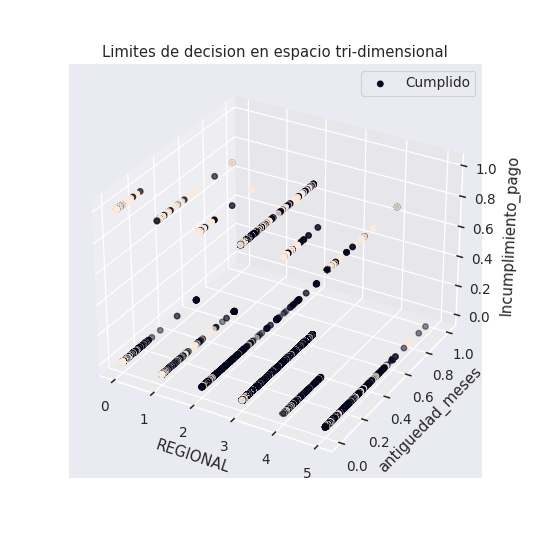

In [26]:
# %matplotlib notebook 
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
# vis_data =  data[['antiguedad_meses','Incumplimiento_pago', 'REGIONAL', 'svm_pred']].copy()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection = '3d')

region_encoder = LabelEncoder().fit(vis_data['REGIONAL'])
x = region_encoder.transform(vis_data['REGIONAL'])

y = vis_data['antiguedad_meses']
z = vis_data['Incumplimiento_pago']

ax.set_xlabel("REGIONAL")
ax.set_zlabel("Incumplimiento_pago")
ax.set_ylabel("antiguedad_meses")
c= [np.round(prob) for prob in vis_data['tree_pred']]
ax.scatter(x, y, z, c= c)
plt.title('Limites de decision en espacio tri-dimensional')
plt.show()
plt.legend(labels)
fig = _

Utilizando un gráfico tridimensional es posible localizar las agrupaciones generadas por el modelo entrenado y compararlas con la variable objetiva. En este caso, podemos ver que el modelo genera una mayor densidad de clasificaciones positivas (puntos blancos) en el rango superior del eje Z (incumplidos) y en especial, en la zona en que los ejes de región y  antigüedad tienden a 0, respaldando nuestra hipótesis sobre el perfil de riesgo. Adicionalmente, podemos estudiar el gráfico como una representación visual de las capacidades del modelo, donde se observan puntos blancos (falsos positivos) en la zona inferior del eje (cumplidos) representando los límites de sensibilidad y precisión obtenidos por el algoritmo. 

# Clustering

Adicionalmente se analizan tecnicas de clusterizacion implementando K-means con 3 grupos con la intencion de agrupar los clientes según el nivel de riesgo. 

In [18]:
from sklearn.cluster import KMeans
y_pred =  np.array(vis_data['tree_pred'])
X_cluster = np.append(X, y_pred.reshape(-1,1) , axis=1)
# X_cluster = X
print(f'X cluster shape {X_cluster.shape}')
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_cluster)
X_pred = kmeans.predict(X_cluster)
vis_data['cluster'] = X_pred

X cluster shape (18264, 32)


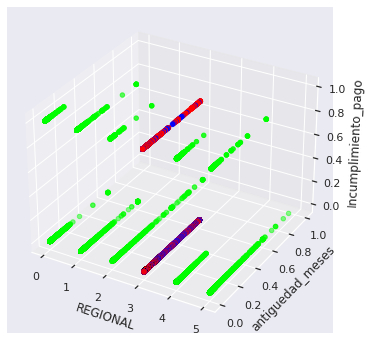

In [19]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection = '3d')

region_encoder = LabelEncoder().fit(vis_data['REGIONAL'])
x = region_encoder.transform(vis_data['REGIONAL'])

y = vis_data['antiguedad_meses']
z = vis_data['Incumplimiento_pago']

ax.set_xlabel("REGIONAL")
ax.set_zlabel("Incumplimiento_pago")
ax.set_ylabel("antiguedad_meses")

c = OneHotEncoder().fit_transform(np.array(vis_data['cluster']).reshape(-1,1)).toarray()
ax.scatter(x, y, z, c= c)
plt.show()

El método de agrupación  propuesto no logra separar el espacio en grupos coherentes que puedan ser interpretados con relación al nivel de riesgo y por ende, no son útiles para la determinación de los grupos de estrategias a implementar. 